In [2]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Plot settings
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['figure.dpi'] = 150
sns.set()

In [3]:
data = pd.read_csv('Data/Animal_Shelter_Intake_and_Outcome.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22515 entries, 0 to 22514
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  16683 non-null  object 
 1   Type                  22515 non-null  object 
 2   Breed                 22515 non-null  object 
 3   Color                 22515 non-null  object 
 4   Sex                   22515 non-null  object 
 5   Size                  22482 non-null  object 
 6   Date Of Birth         16978 non-null  object 
 7   Impound Number        22515 non-null  object 
 8   Kennel Number         22498 non-null  object 
 9   Animal ID             22515 non-null  object 
 10  Intake Date           22515 non-null  object 
 11  Outcome Date          22387 non-null  object 
 12  Days in Shelter       22515 non-null  int64  
 13  Intake Type           22515 non-null  object 
 14  Intake Subtype        22515 non-null  object 
 15  Outcome Type       

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,...,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count
0,NaN,OTHER,CHICKEN,BROWN,Female,SMALL,NaN,K22-040689,VET,A409950,...,FIELD,NaN,NaN,UNKNOWN,NaN,SANTA ROSA,NaN,NaN,NaN,1
1,NaN,OTHER,GOAT,WHITE,Female,LARGE,NaN,K22-040690,AUC YARD,A409951,...,FIELD,NaN,NaN,HEALTHY,NaN,COUNTY,NaN,NaN,NaN,1
2,REMY,DOG,BEAGLE,BLACK/WHITE,Female,MED,04/11/2014,K21-039564,DS69,A406645,...,PHONE,RETURN TO OWNER,OVER THE COUNTER_WEB,UNKNOWN,PENDING,SANTA ROSA,SANTA ROSA,95407.0,"95407(38.403734, -122.736775)",1
3,*RONDE,DOG,CHIHUAHUA SH,TAN,Neutered,SMALL,07/24/2020,K21-039133,DA30,A406003,...,FIELD,ADOPTION,SCAS WEB,HEALTHY,HEALTHY,SANTA ROSA,*PETALUMA,94954.0,"94954(38.245316, -122.59871)",1
4,*SNOOP,CAT,DOMESTIC SH,GRAY,Neutered,SMALL,08/04/2019,K21-039232,CA02,A406151,...,FIELD,ADOPTION,SCAS WEB,HEALTHY,HEALTHY,SANTA ROSA,SANTA ROSA,95405.0,"95405(38.439152, -122.672541)",1


In [4]:
data['Name'] = data['Name'].fillna('Unknown')
data['Outcome Type'] = data['Outcome Type'].fillna('Unknown')
data['Outcome Subtype'] = data['Outcome Subtype'].fillna('Unknown')
data['Outcome Condition'] = data['Outcome Condition'].fillna('Unknown')
data = data.drop(['Outcome Zip Code','Location', 'Count'], axis=1)

## 1. Basic Data Analysis

### Create two new variables that show the age of animal (in months) at the intake and age at the outcome.

In [5]:
import datetime as dt

# Convert variables to datetime format
data['Date Of Birth'] = pd.to_datetime(data['Date Of Birth'])
data['Intake Date'] = pd.to_datetime(data['Intake Date'])
data['Outcome Date'] = pd.to_datetime(data['Outcome Date'])
# Compute the age in months at intake
data['Age (months) at Intake'] = ((data['Intake Date'] - data['Date Of Birth'])/np.timedelta64(1, 'M'))
data['Age (months) at Intake'] = data['Age (months) at Intake'].fillna(-1).astype(int)
# Compute the age in months at outcome
data['Age (months) at Outcome'] = ((data['Outcome Date'] - data['Date Of Birth'])/np.timedelta64(1, 'M'))
data['Age (months) at Outcome'] = data['Age (months) at Outcome'].fillna(-1).astype(int)
data.head()

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,...,Intake Type,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Age (months) at Intake,Age (months) at Outcome
0,Unknown,OTHER,CHICKEN,BROWN,Female,SMALL,NaT,K22-040689,VET,A409950,...,STRAY,FIELD,Unknown,Unknown,UNKNOWN,Unknown,SANTA ROSA,NaN,-1,-1
1,Unknown,OTHER,GOAT,WHITE,Female,LARGE,NaT,K22-040690,AUC YARD,A409951,...,STRAY,FIELD,Unknown,Unknown,HEALTHY,Unknown,COUNTY,NaN,-1,-1
2,REMY,DOG,BEAGLE,BLACK/WHITE,Female,MED,2014-04-11,K21-039564,DS69,A406645,...,STRAY,PHONE,RETURN TO OWNER,OVER THE COUNTER_WEB,UNKNOWN,PENDING,SANTA ROSA,SANTA ROSA,88,89
3,*RONDE,DOG,CHIHUAHUA SH,TAN,Neutered,SMALL,2020-07-24,K21-039133,DA30,A406003,...,STRAY,FIELD,ADOPTION,SCAS WEB,HEALTHY,HEALTHY,SANTA ROSA,*PETALUMA,11,13
4,*SNOOP,CAT,DOMESTIC SH,GRAY,Neutered,SMALL,2019-08-04,K21-039232,CA02,A406151,...,STRAY,FIELD,ADOPTION,SCAS WEB,HEALTHY,HEALTHY,SANTA ROSA,SANTA ROSA,24,25


### Distribution/Histogram Plot of Ages at Intake

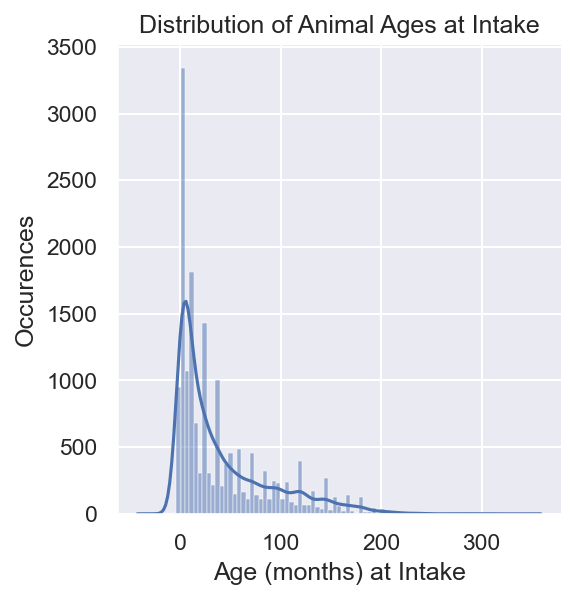

In [6]:
known_ages = data.loc[data['Age (months) at Intake'] != -1]
dist_plot = sns.displot(data=known_ages, x='Age (months) at Intake',kde=True, height=4)
dist_plot.set_axis_labels("Age (months) at Intake", "Occurences")
dist_plot.set(title="Distribution of Animal Ages at Intake")

### Analysis of Animal Types in the dataset

DOG accounts for 56.5667332889185 % of the dataset
CAT accounts for 35.37641572285143 % of the dataset
OTHER accounts for 8.05685098823007 % of the dataset


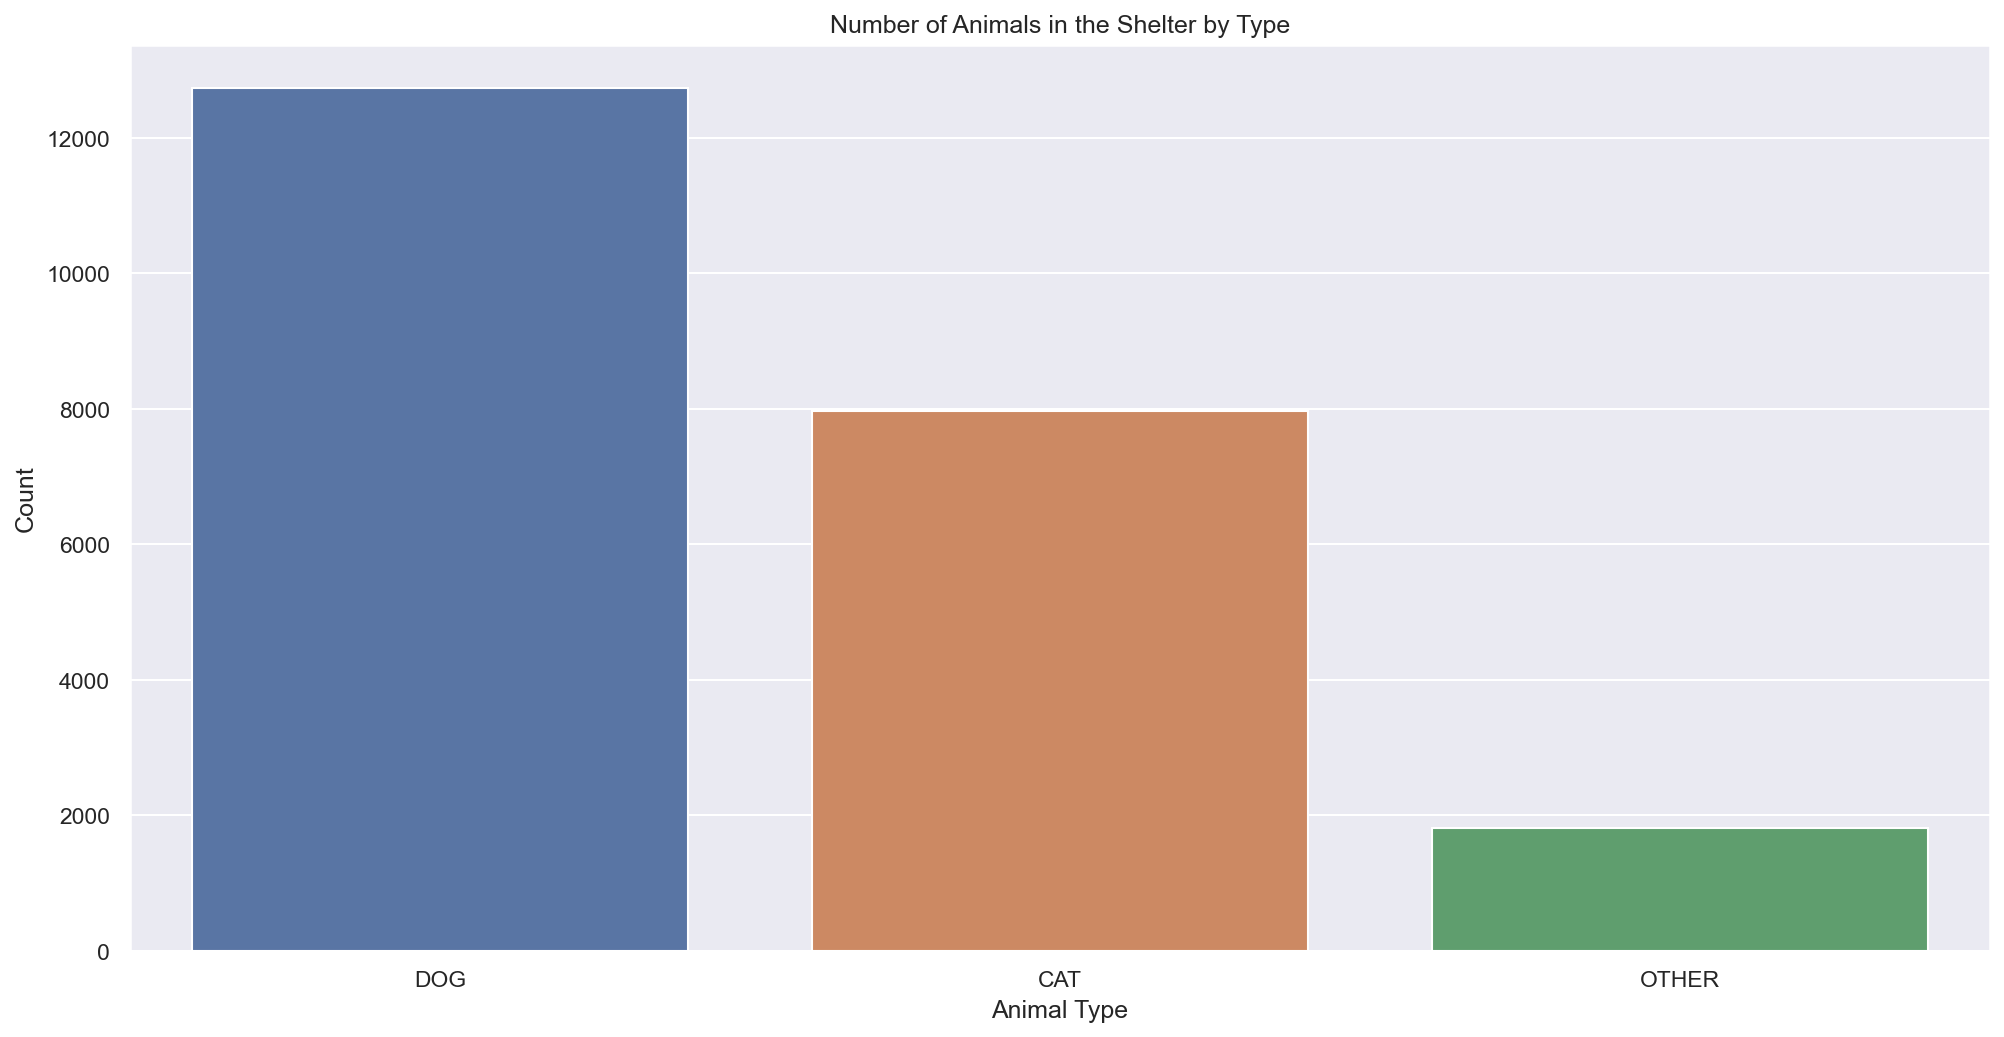

In [11]:
animal_type = data['Type'].value_counts()
animal_type = pd.DataFrame(animal_type)

types_barplot = sns.barplot(data=animal_type,x=animal_type.index, y='Type')
types_barplot.set(title='Number of Animals in the Shelter by Type', xlabel='Animal Type', ylabel='Count')

for index, row in animal_type.iterrows():
    percentage = (row['Type']/animal_type['Type'].sum()) * 100
    print(index, 'accounts for', percentage, '% of the dataset')

<AxesSubplot:xlabel='Size', ylabel='count'>

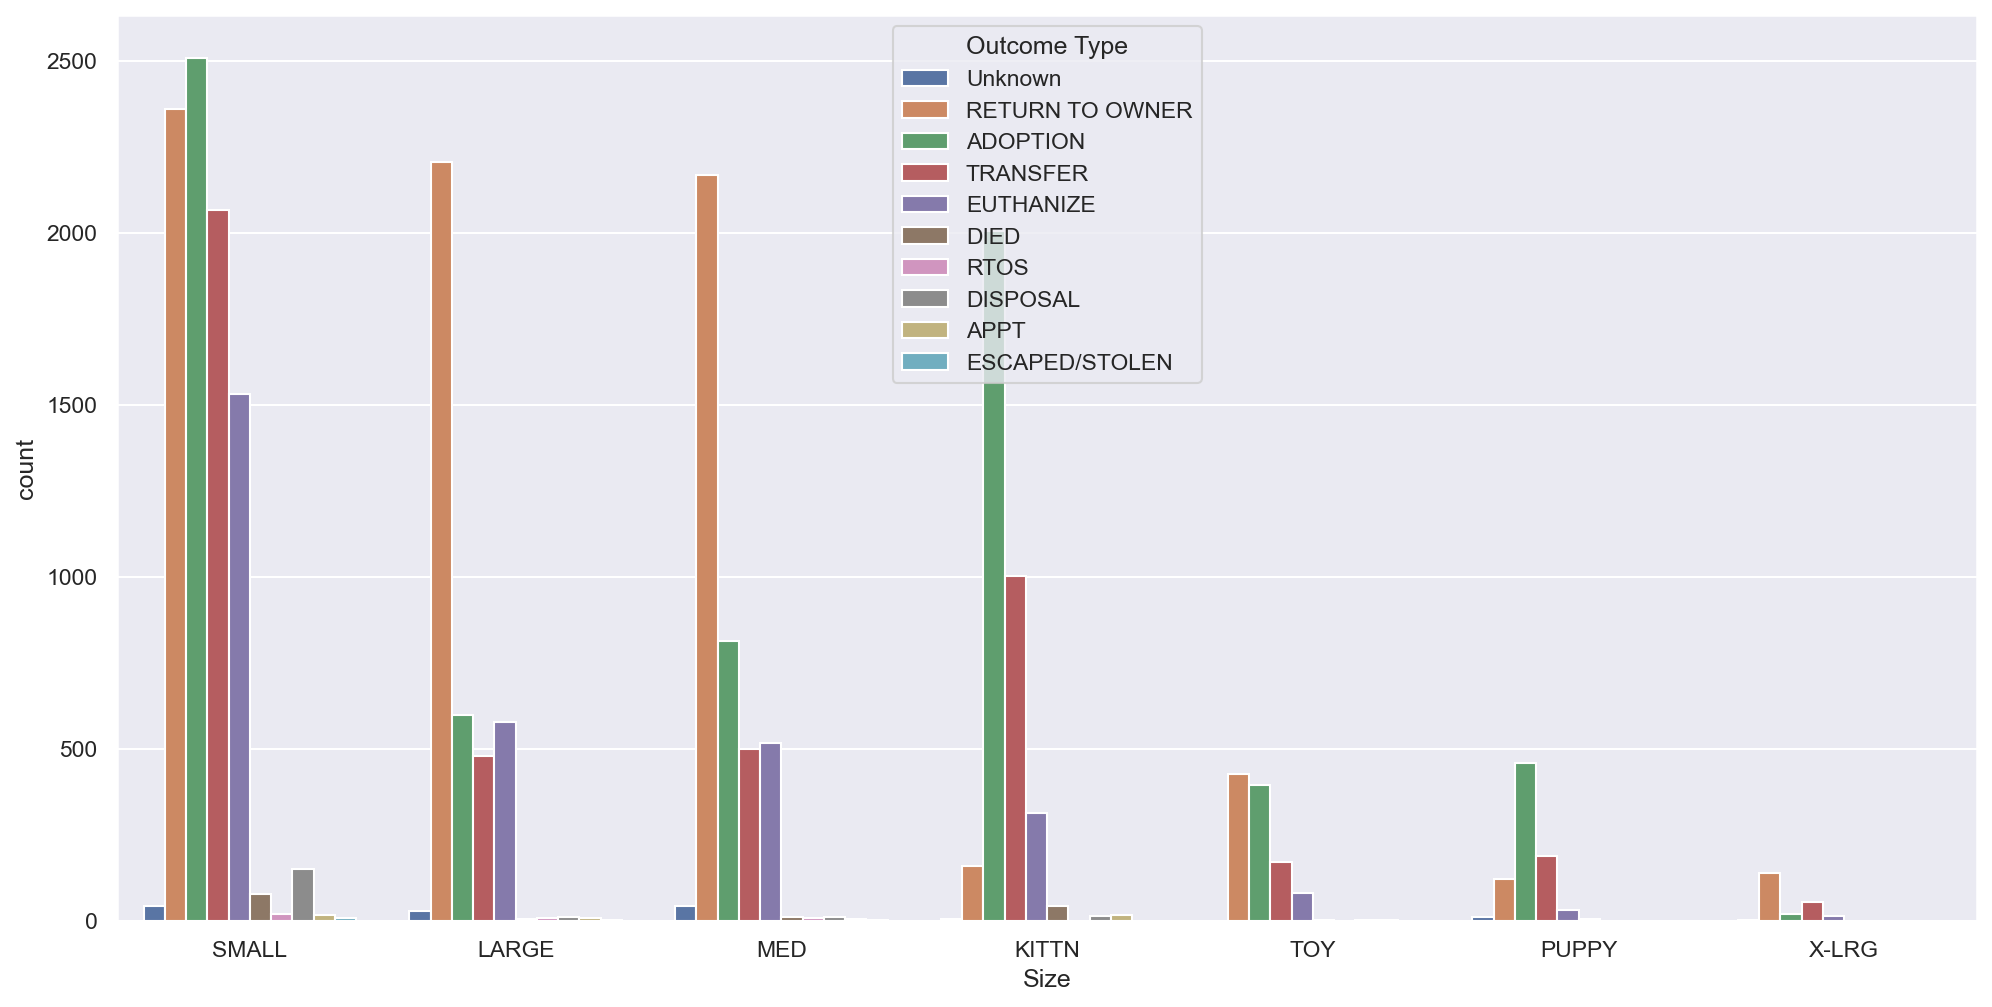

In [14]:
sns.countplot(data=data, x='Size', hue='Outcome Type')